<a href="https://colab.research.google.com/github/leighTOR/fishlens-efficientnet/blob/main/fishlens_efficientnetv6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch
!pip install torch torchvision
!pip install roboflow

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=70ae26a80f86944c2e3f43557a0ec00350ca174fabbf1ece5401fc7e5c930100
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
import numpy as np
from roboflow import Roboflow
import seaborn as sns
import csv
import time

In [3]:
# Roboflow dataset loading
rf = Roboflow(api_key="W65oY4Om8xYEo0mK9UED")
project = rf.workspace("fishlens").project("fishlens-modelv1")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fishlens-modelv1-2 in yolov5pytorch:: 100%|██████████| 15012/15012 [00:02<00:00, 5969.96it/s]


In [4]:
# Define the dataset class
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def collate_fn(self, batch):
        images, labels = zip(*batch)
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)


In [5]:
# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
# Setup directories
train_image_dir = '/content/fishlens-modelv1-2/train/images'
train_label_dir = '/content/fishlens-modelv1-2/train/labels'
val_image_dir = '/content/fishlens-modelv1-2/valid/images'
val_label_dir = '/content/fishlens-modelv1-2/valid/labels'

# Create datasets and dataloaders
train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Load and modify EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 11
model._fc = nn.Linear(model._fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 39.6MB/s]


Loaded pretrained weights for efficientnet-b0


In [7]:
# Training loop
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        class_labels = labels[:, 0, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels


In [12]:
# Function to calculate precision, recall, F1, and mAP
def calculate_metrics(all_labels, all_preds):
    # Convert lists to 2D numpy arrays
    all_labels = np.array(all_labels).reshape(-1, 1)
    all_preds = np.array(all_preds).reshape(-1, 1)

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    mAP = average_precision_score(all_labels, all_preds, average='macro')
    return precision, recall, f1, mAP

In [13]:

# Main training loop with time indicator and metrics storage
num_epochs = 5
save_dir = "/content/metrics"
os.makedirs(save_dir, exist_ok=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s, mAPs = [], [], [], []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_accuracy, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    precision, recall, f1, mAP = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    mAPs.append(mAP)

    epoch_time = time.time() - start_time

    print(f'Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mAP: {mAP:.4f}')


Epoch 1/5 | Time: 82.52s
Train Loss: 0.3702, Train Accuracy: 87.72%
Val Loss: 0.6461, Val Accuracy: 84.75%
Precision: 0.8360, Recall: 0.8331, F1 Score: 0.8309, mAP: 0.0548
Epoch 2/5 | Time: 82.66s
Train Loss: 0.2574, Train Accuracy: 91.68%
Val Loss: 1.1410, Val Accuracy: 69.49%
Precision: 0.7255, Recall: 0.6704, F1 Score: 0.6646, mAP: 0.0557
Epoch 3/5 | Time: 82.44s
Train Loss: 0.2002, Train Accuracy: 92.98%
Val Loss: 0.7762, Val Accuracy: 83.90%
Precision: 0.8424, Recall: 0.8364, F1 Score: 0.8231, mAP: 0.0637
Epoch 4/5 | Time: 81.75s
Train Loss: 0.2236, Train Accuracy: 93.10%
Val Loss: 0.9884, Val Accuracy: 79.24%
Precision: 0.8095, Recall: 0.7991, F1 Score: 0.7952, mAP: 0.0541
Epoch 5/5 | Time: 82.79s
Train Loss: 0.1826, Train Accuracy: 94.18%
Val Loss: 0.8455, Val Accuracy: 82.63%
Precision: 0.8195, Recall: 0.8415, F1 Score: 0.8251, mAP: 0.0557


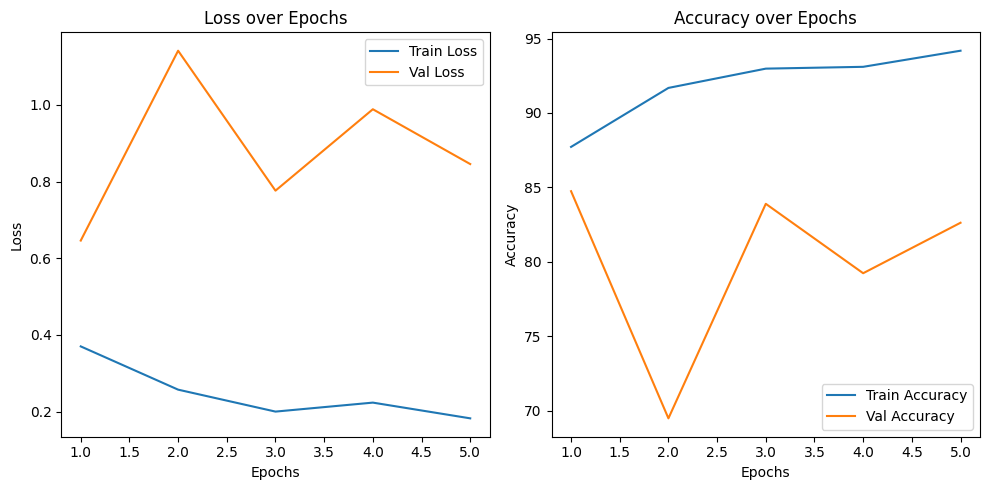

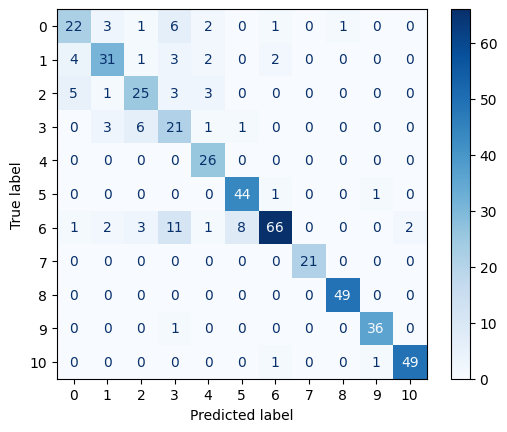

Metrics and plots are saved in /content/metrics


In [16]:
# Save results to CSV
with open(f'{save_dir}/metrics_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_epochs):
        writer.writerow({
            'Epoch': i + 1,
            'Train Loss': train_losses[i],
            'Val Loss': val_losses[i],
            'Train Accuracy': train_accuracies[i],
            'Val Accuracy': val_accuracies[i],
            'Precision': precisions[i],
            'Recall': recalls[i],
            'F1 Score': f1s[i],
            'mAP': mAPs[i]
        })

# Final graph plotting after the last epoch
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/loss_accuracy_plot.png")
    plt.show()

# Display confusion matrix
def plot_confusion_matrix(val_labels, val_preds, num_classes):
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"{save_dir}/confusion_matrix.png")
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(val_labels, val_preds, num_classes)

print(f"Metrics and plots are saved in {save_dir}");